In [1]:
"""
    Copyright (c) 2023 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 02/05/2023

    Code description :
    __________________
    Compare differents optimisation algorithms for inverting the interferometric
    lensless endoscopy model in terms of quality of reconstruction, as well as speed.
    PyUnLocBox, SPGL1 and PyProximal toolboxes are used here.
    The observation model is the fast autocorrelation-based one.
    The object of interest is in 1D.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers
import pylops
import pyproximal
import spgl1

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from IHT import IHT
from functions import *
from graphics import show_rec1D

In [2]:
"Parameters"
N = 256 # vector size
K = 6 # sparsity
Q = 80 # Number of cores
M = 80 # Number of observations y
maxit=800 # Maximum number of iterations

"Define the sparse object"
f = np.zeros(N)
indices = np.random.permutation(np.arange(N))[:K] 
f[indices[:-1]] = np.random.randn(K-1)
f[indices[-1]] = -np.sum(f)

" From analytical developments, beware of the np.conj!!"
pos_cores = np.random.permutation(np.arange(N))[:Q] # random cores locations (/!\ Indices)
# pos_cores = np.round(np.arange(Q)*(N-1)/(Q-1)).astype(int) # regularly spaced cores locations
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2) # Complex amplitude input to each core

"Define Om = {p_j - p_k, j,k \in [Q]}"
Om = np.subtract.outer(pos_cores, pos_cores).astype(int)

"Observation model"
beta = np.zeros((M,N), dtype=complex)
beta[:, pos_cores] = a_ij
beta2 = corr_circ(np.conj(beta)) # autocorrelations of beta

g = lambda x: np.real(beta2@T(x))/np.sqrt(M) # Note: it should be the conj of beta but same as it's random
gt = lambda x: np.real(T_star(beta2.conj().T@x))/np.sqrt(M)
nu_rop = eval_nu(np.random.randn(N), g, gt, nb_iter=50)*1.01
y = g(f) # The M real observations
# x0 = gt(y)

### Gradient Descent

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 
\end{equation*}

using Gradient Descent algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) 
\end{equation*}

with PyUnLocBox toolbox.

INFO: Dummy objective function added.
Solution found after 5000 iterations:
    objective function f(sol) = 3.591693e-23
    stopping criterion: MAXIT


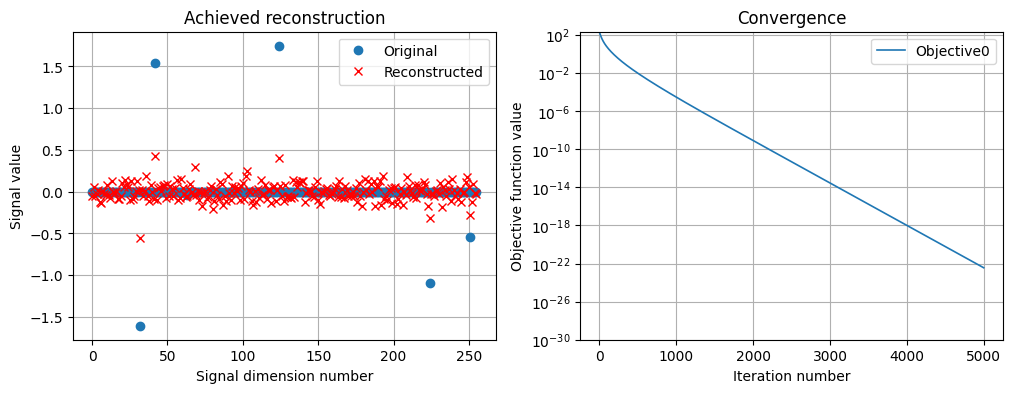

SNR: 1.49 dB


In [3]:
"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop)

x0 = np.zeros(f.shape)
solver = solvers.gradient_descent(step=1/nu_rop)
ret = solvers.solve([f2], x0, solver, rtol=1e-7, maxit=5000, verbosity='LOW')
obj_GD = np.array(ret['objective'])[:,0]

show_rec1D(f, ret['sol'], objective=obj_GD)

### Forward-Backward

Solve
\begin{equation*}
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_1
\end{equation*}

using Forward-Backward algorithm:

\begin{equation*}
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
\end{equation*}

with PyUnLocBox toolbox.

Solution found after 800 iterations:
    objective function f(sol) = 3.281892e+00
    stopping criterion: MAXIT


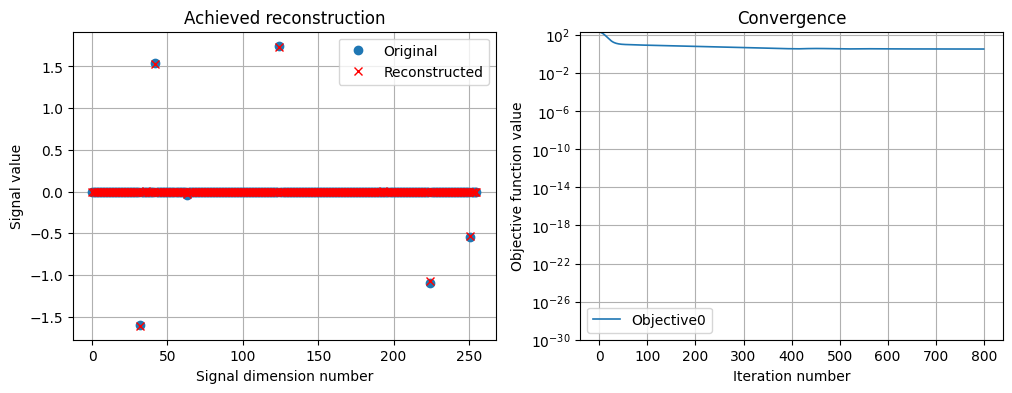

SNR: 38.12 dB


In [4]:
"Solver parameters"
solver = solvers.forward_backward(step=0.5/nu_rop )

"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop)
lamb = 0.5
f1 = functions.norm_l1(lambda_=lamb)

ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=maxit, verbosity='LOW')

show_rec1D(f, ret2['sol'], np.sum(np.array(ret2['objective']),1))

With PyProximal toolbox.

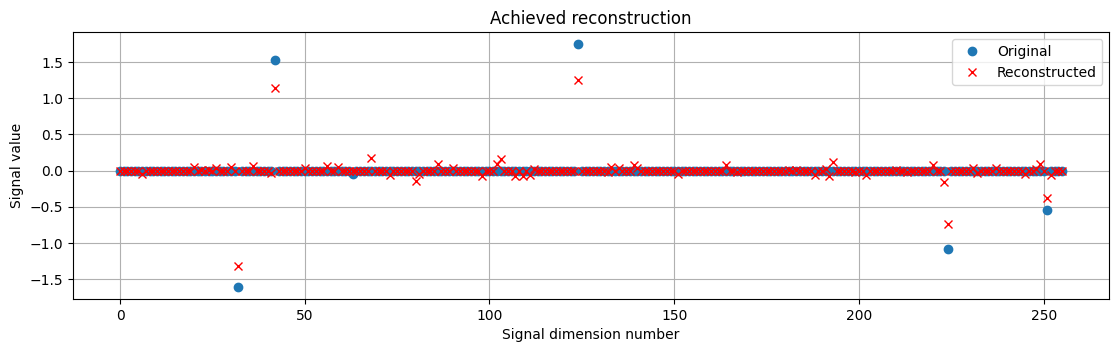

SNR: 10.40 dB


In [5]:
"L1 norm regularisation"
l1 = pyproximal.L1(sigma=1)
"L2 data fidelity term"
A_ROP = pylops.ROP(a_ij, diagless=True, dtype=np.complex128)
# SOm = pylops.Restriction(N, Om.reshape(-1), dtype=np.complex128)
SOm = pylops.S_Om_1D(N, Om)
fft_op = pylops.signalprocessing.FFT(dims=N)
A_op = A_ROP*SOm*fft_op

g2 = lambda x: A_op@x
g2t = lambda y:A_op.H@y
nu_rop2 = eval_nu(np.random.randn(N), g2, g2t, nb_iter=50)*1.01
l2 = pyproximal.L2(Op=A_op, b=y, niter=10)
xhat = pyproximal.optimization.primal.ProximalGradient(\
                                    proxf=l2, proxg=l1, x0=x0, tau=0.5/nu_rop2, niter=200)

show_rec1D(f, np.real(xhat), objective=None, log_scale=True, linewidth=1.2) 

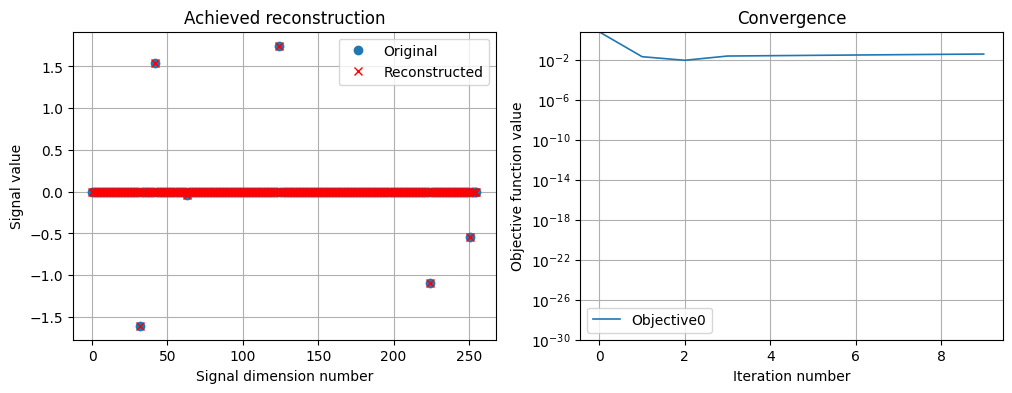

SNR: 83.41 dB


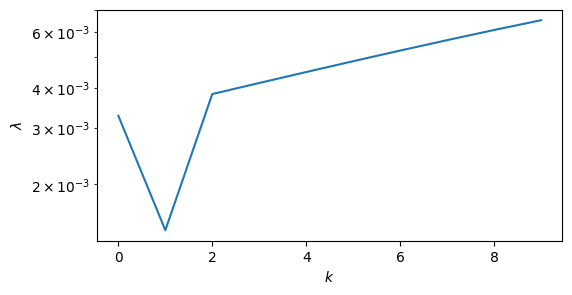

In [6]:
"Solver parameters"
solver = solvers.forward_backward(step=0.5/nu_rop )
SNR_target = 70
epsilon = np.linalg.norm(f)*10**(-SNR_target/20)
bigit = 10

"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop)

f_hat = np.zeros(f.shape)
lambs = np.zeros(bigit)
objectives = np.zeros(bigit)
lamb = 1
i=0
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat
    f1 = functions.norm_l1(lambda_=lamb)
    ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=maxit, verbosity='NONE')
    f_hat = ret2['sol']
    lamb *= epsilon/np.linalg.norm(g(ret2['sol'])-y)
    lambs[i] = lamb
    objectives[i] = np.sum(np.array(ret2['objective'])[-1,:])
    i+=1

show_rec1D(f, ret2['sol'], objectives)

plt.figure(figsize=(6,3))
plt.plot(lambs, linewidth=1.5)
plt.yscale('log')
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$k$')
plt.show()

## Iterative Hard Thresholding (IHT)

\begin{align*}
    x^{(k+1)} &= \mathcal{H}_K \left( x^{(k)} + \gamma \boldsymbol{\Phi}^* 
    (\boldsymbol y - \boldsymbol\Phi x^{(k)}) \right) \\
    &= \mathcal{H}_K \left( x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right).
\end{align*}

Hence, $\mathcal{H}_K$ plays the role of the proximal operator for the $\ell_0$ norm.

Tolerance reached at iteration 4314: |X_n1-X_n|=1e-08


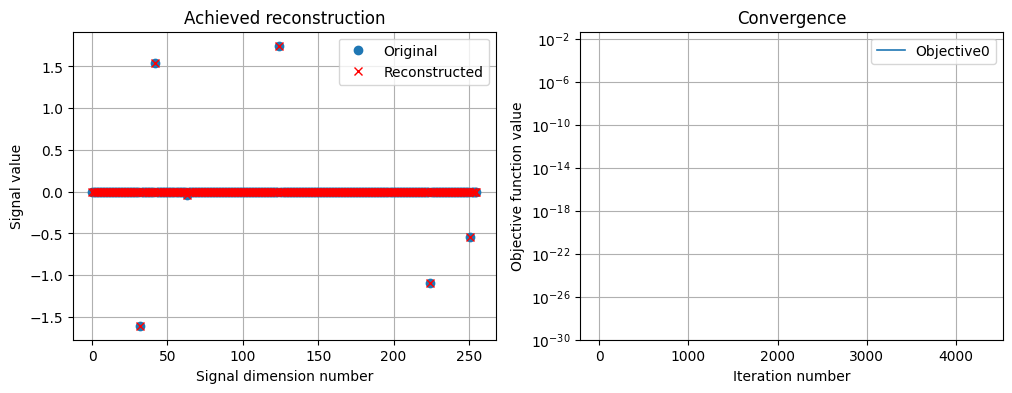

SNR: 116.24 dB


In [7]:
xn, diffs, obj_IHT = IHT(x0, y, s=K+5, A=g, At=gt, nu=0.5/nu_rop, lamb=lamb, maxit=10000, mode='L2', verbosity='low')

show_rec1D(f, xn, objective=obj_IHT)

## SPGL1

The SNR is defined as:
\begin{equation*}
    SNR = 20 \log \left( \frac{\lVert f \rVert_2}{\lVert f - \hat{f} \rVert_2} \right)
\end{equation*}

We thus target an error of:
\begin{equation*}
    \lVert f - \hat{f} \rVert_2 = \lVert f \rVert_2 ~10^{SNR/20}
\end{equation*}

Where the SNR value can be changed.

Solves 3 problems:

**Lasso problem**
\begin{equation*}
    \min_x~\frac{1}{2} \lVert Ax - b \lVert_2^2 \text{ s.t. } \lVert x \rVert_1 \le \tau
\end{equation*}

**Basis Pursuit DeNoise (BPDN)**
\begin{equation*}
    \min_x~ \lVert x \rVert_1 \text{ s.t. } \lVert Ax - b \lVert_2 \le \sigma
\end{equation*}

**Basis Pursuit (BP)**
\begin{equation*}
    \min_x~ \lVert x \rVert_1 \text{ s.t. } Ax = b 
\end{equation*}

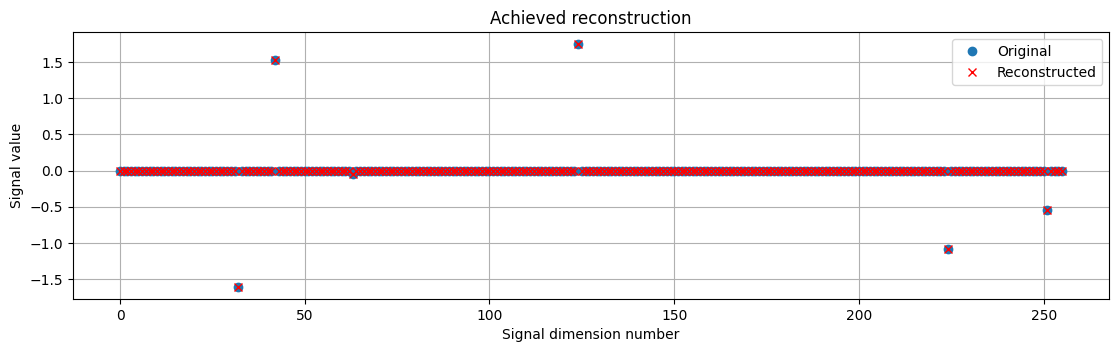

SNR: 107.31 dB
SNR: 107.54 dB
SNR: 83.38 dB


In [8]:
# bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=1e-8, bp_tol=1e-8, iscomplex=False)[0]
SNR_target = 100
opt_tol = np.linalg.norm(f)*10**(-SNR_target/20)
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=opt_tol)[0]
bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma, opt_tol=opt_tol)[0]
lasso = lambda A, b, tau: spgl1.spg_lasso(A, b, tau, opt_tol=opt_tol)[0]

A_corr = Autocorr_model(beta2, wt=None)
A_corr_r = Op2Real(A_corr)
y_corr_r = A_corr_r@f
x_corr = bpalg(A_corr_r, y_corr_r)
x_corr2 = bpdnalg(A_corr_r, y_corr_r,1e-10)
x_corr_lasso = lasso(A_corr_r, y_corr_r, tau=np.linalg.norm(f,1))

show_rec1D(f, x_corr)

print('SNR: {:.2f} dB'.format(snr(f, x_corr2)) )
print('SNR: {:.2f} dB'.format(snr(f, x_corr_lasso)) )

With ROP model instead of autocorrelative one

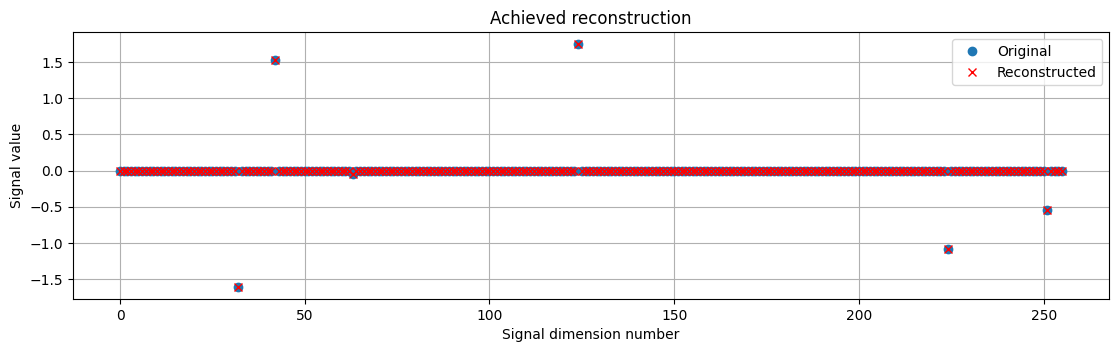

SNR: 107.72 dB


In [9]:
A_ROP = ROP_model(Om, a_ij, N)
A_ROP_r = Op2Real(A_ROP)
y_ROP_r = A_ROP_r@f
x_ROP = bpalg(A_ROP_r, y_ROP_r)
show_rec1D(f, x_ROP )

TwIST (Two-step Iterative Shrinkage/Threshold)

\begin{equation*}
    \boldsymbol x = \argmin_{\boldsymbol x}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Ax} \rVert_2^2 + g(\boldsymbol x)
\end{equation*}

The TwIST algorithm can be expressed by the following recursion:
\begin{equation*}
    \boldsymbol x^{(k+1)} = (1-\alpha) \boldsymbol x^{(k-1)} + (\alpha-\beta) \boldsymbol x^{(k)} + \beta \text{prox}_g \left(\boldsymbol x^{(k)} + \boldsymbol A^H(\boldsymbol y- \boldsymbol{Ax}^{(k)}) \right),
\end{equation*}

where $\boldsymbol x^{(1)} = \text{prox}_g (\boldsymbol x^{(0)} + \boldsymbol A^H (\boldsymbol y- \boldsymbol{Ax}^{(0)}) ) $

The optimal weighting parameters $\alpha$ and $\beta$ are linked to the smallest and largest eigenvalues of $\boldsymbol A^H \boldsymbol A$ as follows:

\begin{align*}
    \alpha &= 1 + \rho^2 \\
    \beta &= \frac{2\alpha}{\Lambda_{\text{max}} + \lambda_{\text{min}} }
\end{align*}

where $\rho = \frac{1-\sqrt k}{1 + \sqrt k}$ with $k = \frac{\lambda_{\text{min}}}{\Lambda_{\text{max}}}$ and $\Lambda_{\text{max}} = \text{max}(1, \lambda_{\text{max}})$.

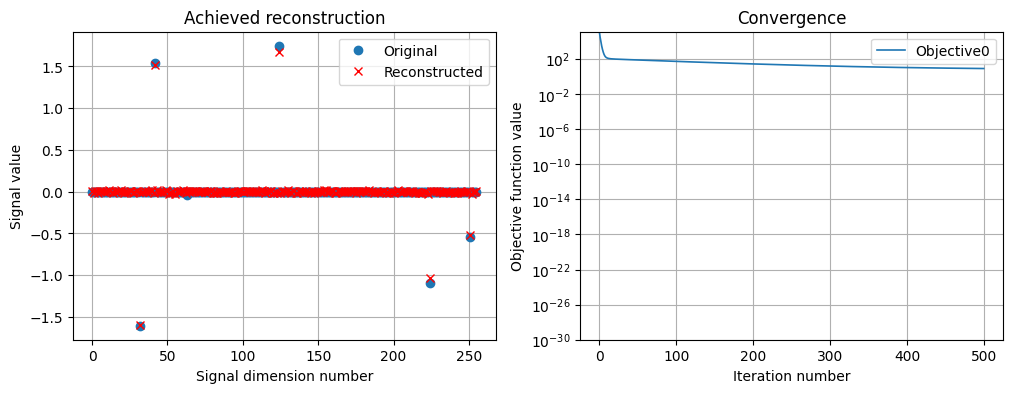

SNR: 24.41 dB


In [10]:
"L1 norm regularisation"
l1 = pyproximal.L1(sigma=1)
"L2 data fidelity term"
A_ROP = pylops.ROP(a_ij, diagless=True, dtype=np.complex128)
SOm = pylops.S_Om_1D(N, Om)
# SOm = pylops.Restriction(N, Om.reshape(-1), dtype=np.complex128) # Restriction from PyLops does not work well, probably it does not handle complex values well.
fft_op = pylops.signalprocessing.FFT(dims=N)
A_op = A_ROP*SOm*fft_op

g2 = lambda x: A_op@x
g2t = lambda y:A_op.H@y
nu_rop2 = eval_nu(np.random.randn(N), g2, g2t, nb_iter=50)*1.01

eigs = (A_op.H * A_op).eigs()
eigs = (np.max(np.abs(eigs)), np.min(np.abs(eigs)))

x0 = np.zeros(f.shape)
xhat, objective = pyproximal.optimization.primal.TwIST(\
                                    proxg=l1, A=A_op, b=y, x0=x0, \
                                    alpha = 1, beta=8e-3, \
                                    eigs=eigs, niter=500, show=False, \
                                    returncost=True)
show_rec1D(f, np.real(xhat), objective=objective, log_scale=True, linewidth=1.2)                               

Douglas-Rachford

Solve 
\begin{equation*}
    x^* = \argmin_u~f(u) + g(u)
\end{equation*}

applying

\begin{align*}
     x^{(k+1)} &:= \text{prox}_{\gamma f}(z^{(k)}-u^{(k)}) \\
     z^{(k+1)} &:= \text{prox}_{\gamma g}(x^{(k+1)}+u^{(k)}) \\
     u^{(k+1)} &:= u^{(k)} + x^{(k+1)} - z^{(k+1)}.
\end{align*}

Solution found after 19 iterations:
    objective function f(sol) = 1.981260e+02
    stopping criterion: RTOL


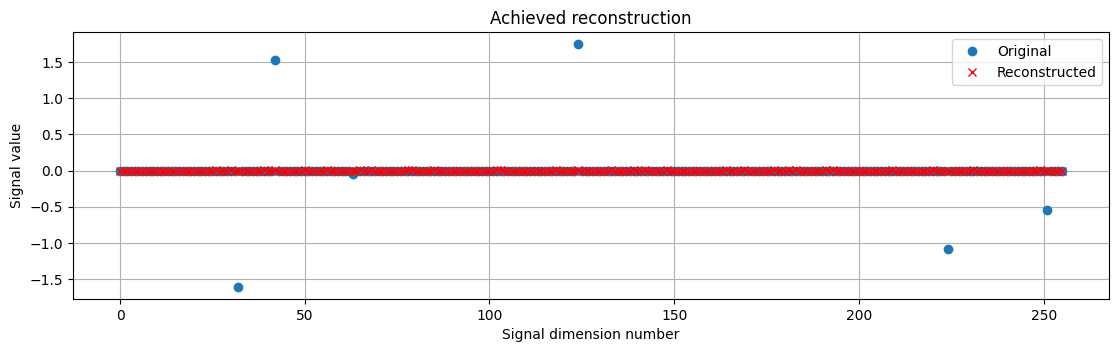

SNR: 0.03 dB


In [11]:
"Solver parameters"
solver = solvers.douglas_rachford(step=0.5/nu_rop )

"Reconstruction"
f2 = functions.norm_l2(y=y, A=g, At=gt, nu=nu_rop, tight=True)
f1 = functions.norm_l1(lambda_=1e-2)
ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=maxit, verbosity='LOW')

show_rec1D(f, ret2['sol'])

# Noisy case

In [12]:
def plotrec(x, x_hat):
    plt.figure()
    plt.plot(x, 'o', label='Original')
    plt.plot(x_hat, 'xr', label='Reconstructed')
    plt.grid(True)
    plt.title('Achieved reconstruction')
    plt.legend(numpoints=1)
    plt.xlabel('Signal dimension number')
    plt.ylabel('Signal value')
    plt.show()

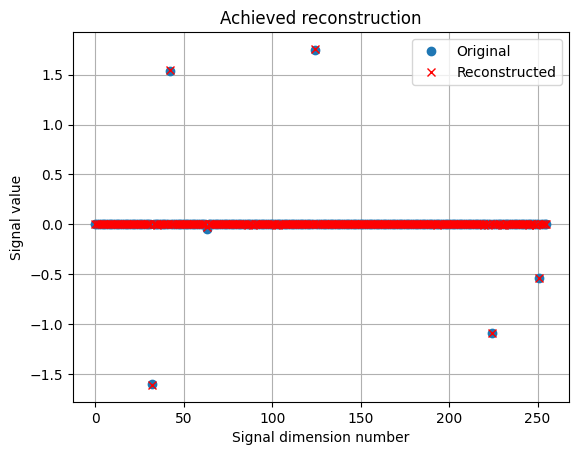

SNR: 40.19 dB


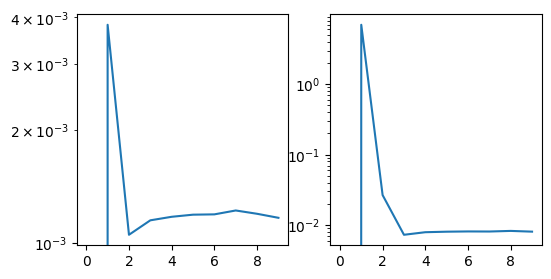

In [13]:
sig = 1e-2
noise = sig*np.random.randn(M)

y_noisy = g(f) + noise

"Solver parameters"
solver = solvers.forward_backward(step=1/(2*nu_rop) )
maxit=300
SNR_target = 70
epsilon = np.linalg.norm(f)*10**(-SNR_target/20)
bigit = 10

"Reconstruction"
f2 = functions.norm_l2(y=y_noisy, A=g, At=gt, nu=nu_rop, tight=False)

f_hat2 = np.zeros(f.shape)
lambs2 = np.zeros(bigit)
objectives2 = np.zeros(bigit)
lamb2 = 1
i=1
while (i<bigit): # and snr(f, f_hat)<40):
    x0 = f_hat2
    f1 = functions.norm_l1(lambda_=lamb2)
    ret2 = solvers.solve([f1, f2], x0, solver, rtol=1e-9, maxit=maxit, verbosity='NONE')
    f_hat2 = ret2['sol']
    lamb2 *= epsilon/np.linalg.norm(g(ret2['sol'])-y_noisy)
    lambs2[i] = lamb2
    objectives2[i] = np.sum(np.array(ret2['objective'])[-1,:])
    i+=1

plotrec(f, f_hat2)
print('SNR: {:.2f} dB'.format(snr(f, f_hat2)) )

plt.figure(figsize=(6,3))
plt.subplot(121)
plt.plot(lambs2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.subplot(122)
plt.plot(objectives2, linewidth=1.5)
plt.gca().set_yscale('log')
plt.show()

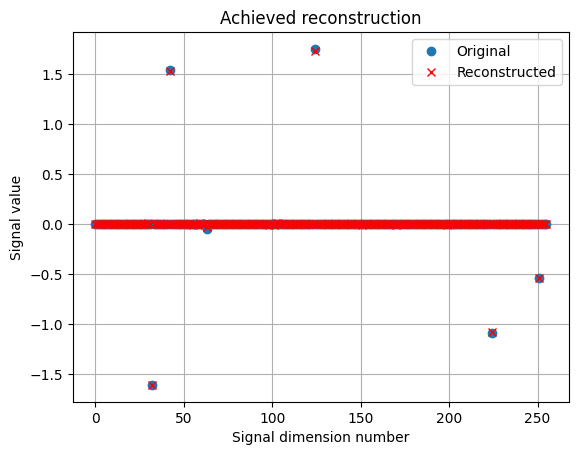

SNR: 37.14 dB


In [14]:
sig = 1e-2
noise = sig*np.random.randn(2*M)

y_noisy = A_corr_r@f + noise
x_noisy = bpdnalg(A_corr_r, y_noisy,1e-8)

plotrec(f, x_noisy)
print('SNR: {:.2f} dB'.format(snr(f, x_noisy)) )